In [24]:
"""
StochasticCells runs a simple homodimerization reaction for a small total number
of molecules N, comparing the approximate continuum dynamics with the true
stochastic dynamics.

You need to complete the following functions to get results
    ** StochasticTrajectory
    ** PlotODEVsStochastic
"""

import scipy
import pylab

"""Global values of rate constants"""
kb = 1.0
ku = 2.0

def dydt(y, t):
    """
    Gives the time evolution law dydt for y = [M,D], in the form needed by
    odeint
    """
    M = y[0]
    D = y[1]
    dMdt = -2 * kb * M**2 + 2 * ku * D
    dDdt = -ku * D + kb * M**2
    return [dMdt, dDdt]


def PlotODE(N, tMax=1.0, dt=0.01):
    """Plots the continuum time evolution of M(t), given N total
    monomer molecules and no dimer molecules at time t=0.
    Uses scipy.arange to produce an array of times; calls
    scipy.integrate.odeint(dydt, y0, times) to get yTrajectory
    M(t) is first column of yTrajectory = yTrajectory[:,0]
    uses pylab.plot to plot times versus M(t)
    """
    y0 = [N, 0.0]
    eps = 1.e-10
    times = scipy.arange(0.0, tMax + eps, dt)
    yTrajectory = scipy.integrate.odeint(dydt, y0, times)
    pylab.plot(times, yTrajectory[:, 0])
    pylab.show()


def StochasticTrajectory(N, tMax=10.0):
    """
    Implements the Gillespie algorithm, as described in the text. If
        t1, t2, t3, ..., tFinal
    are the resulting reaction times and
        M1, M2, M3, ..., MFinal
    are the number of monomers just after each reaction, the routine returns
    an array
        times = [0.0, t1, t1, t2, t2, ..., tFinal, tMax]
    and an array
        Ms = [N, N, M1, M1, M2, M2, ..., MFinal, MFinal]
    (suitable for plotting, since the concentration M(t) = M_n between t_n and
    t_{n+1}, and then abruptly jumps to M_{n+1}). This is easy to do:
    initialize them at t=0, append just before and just after each
    reaction, and add a point at t=tMax.

    To generate tWait:
        Use scipy.stats to generate a random number with an
        exponential distribution of mean 1/gammaTot. This is twait.  
        twait = scipy.stats.expon.rvs(scale=1.0 / gammaTot, size=1)[0]
    To generate r: 
      generate a random number distributed uniformly between 0 an 1 
      (e.g. use: scipy.stats.uniform.rvs(size=1)[0]). Multiply that number by gammaTot.
    
    Notice that, since there are only two reactions, you can just check if
    r > bindingRate to see if you want to bind or unbind.
    """
    t = 0.0
    times = [t]
    M = N
    D = 0
    Ms = [M]
    while True:
      bindingRate = kb * M * (M-1)
      unbindingRate = ku * D
      gammaTot = bindingRate + unbindingRate
      tWait = scipy.stats.expon.rvs(scale=1.0/gammaTot, size=1)[0]
      if t + tWait > tMax:
        times.append(tMax)
        Ms.append(M)
        return times, Ms
      t += tWait
      r = gammaTot * scipy.stats.uniform.rvs(size=1)
      times.append(t)
      Ms.append(M)
      if r < bindingRate:
        M -= 2
        D += 1
      else:
        M += 2
        D -= 1
      times.append(t)
      Ms.append(M) #we're adding these twice for visualization
    

def PlotODEVsStochastic(N, tMax=1.0, dt=0.01):
    """Plots the continuum time evolution of M(t) versus
    the stochastic trajectory given by the Gillespie algorithm.
    Again, N total monomer molecules and no dimer molecules at time t=0.
    """
    y0 = [N, 0]
    eps = 1.e-10
    ODEtimes = scipy.arange(0.0, tMax+eps, dt)
    yTrajectory = scipy.integrate.odeint(dydt, y0, ODEtimes)
    pylab.plot(ODEtimes, yTrajectory[:,0])

    stochasticTimes, stochasticNs = StochasticTrajectory(N, tMax)
    pylab.plot(stochasticTimes, stochasticNs)
    pylab.show()


def PlotODEVsAverageStochastic(N, nAverage, tMax=1.0, dt=0.001):
    """Plots the continuum time evolution of M(t) versus
    the average of nAverage stochastic trajectories.
    Computes the stochastic averages at the same
        times = (dt, 2 dt, ...)
    that odeint uses (except for zero).
    The stochastic simulation returns values at irregular times: how
    can we evaluate M at regular intervals? We can find the stochastic
    interval
      [stochasticTimes[indexStochastic], stochasticTimes[indexStochastic+1])
    containing time[index] by searching forward from the previous interval,
    something like this:
        ...
        indexStochastic = 0
        for index in range(len(times)):
            while (indexStochastic < len(stochasticTimes)) \
                   & (stochasticTimes[indexStochastic+1] < times[index]):
                indexStochastic+=1
            (add stochastic M[indexStochastic] to total M[index]...)
    """
    y0 = [N, 0.0]
    eps = 1.e-10
    times = scipy.arange(dt, tMax + eps, dt)
    yTrajectory = scipy.integrate.odeint(dydt, y0, times)
    pylab.plot(times, yTrajectory[:, 0])
    #
    totalMs = scipy.zeros(len(times), float)
    for i in range(nAverage):
        stochasticTimes, stochasticMs = StochasticTrajectory(N, tMax)
        indexStochastic = 0
        for index in range(len(times)):
            while (indexStochastic < len(stochasticTimes)) \
                    & (stochasticTimes[indexStochastic + 1] < times[index]):
                indexStochastic += 1
            totalMs[index] += stochasticMs[indexStochastic]
    pylab.plot(times, totalMs / nAverage)
    pylab.show()



ODE vs Stochastic....


<ipython-input-24-fe808edfe716>:108: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  ODEtimes = scipy.arange(0.0, tMax+eps, dt)


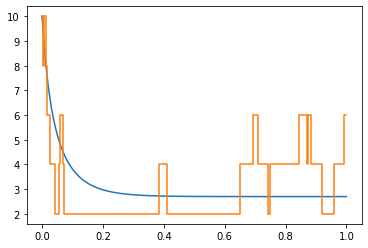

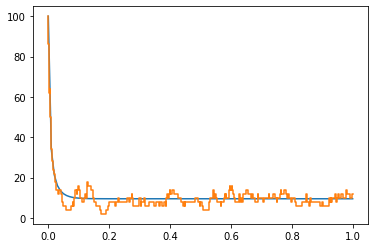

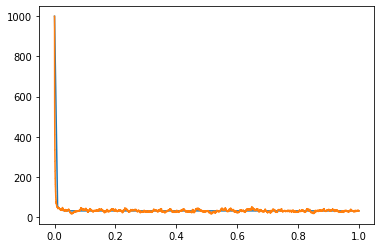

In [25]:
print('ODE vs Stochastic....')
PlotODEVsStochastic(10, tMax = 1.0, dt = 0.01)
PlotODEVsStochastic(100, tMax = 1.0, dt = 0.01)
PlotODEVsStochastic(1000, tMax = 1.0, dt = 0.01)